# Automatic concept annotation

In [1]:
import torch
import torchvision.transforms as T
import clip
import pandas as pd
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
from pathlib import Path
import glob
from PIL import Image
import scipy
import numpy as np
import tqdm
from matplotlib import gridspec
import matplotlib.pyplot as plt

c:\Users\conna\.conda\envs\MONET\lib\site-packages\torch\torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]


# Utils funcs

In [2]:
class ImageDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for loading images and associated metadata.

    Args:
        image_path_list (list): A list of file paths to the images.
        transform (callable): A function/transform to apply to the images.
        metadata_df (pandas.DataFrame, optional): A pandas DataFrame containing metadata for the images.

    Raises:
        AssertionError: If the length of `image_path_list` is not equal to the length of `metadata_df`.

    Returns:
        dict: A dictionary containing the image and metadata (if available) for a given index.

    """

    def __init__(self, image_path_list, transform, metadata_df=None):
        self.image_path_list = image_path_list
        self.transform = transform
        self.metadata_df = metadata_df

        if self.metadata_df is None:
            self.metadata_df = pd.Series(index=self.image_path_list)
        else:
            assert len(self.image_path_list) == len(
                self.metadata_df
            ), "image_path_list and metadata_df must have the same length"
            self.metadata_df.index = self.image_path_list

    def __getitem__(self, idx):
        image = Image.open(self.image_path_list[idx])

        ret = {"image": self.transform(image)}

        if self.metadata_df is not None:
            ret.update({"metadata": self.metadata_df.iloc[idx]})

        return ret

    def __len__(self):
        return len(self.image_path_list)

In [3]:
def custom_collate(batch):
    """Custom collate function for the dataloader.

    Args:
        batch (list): list of dictionaries, each dictionary is a batch of data

    Returns:
        dict: dictionary of collated data
    """

    ret = {}
    for key in batch[0]:
        if isinstance(batch[0][key], pd.Series):
            try:
                ret[key] = pd.concat([d[key] for d in batch], axis=1).T
            except RuntimeError:
                raise RuntimeError(f"Error while concatenating {key}")
        else:
            try:
                ret[key] = torch.utils.data.dataloader.default_collate(
                    [d[key] for d in batch]
                )
            except RuntimeError:
                raise RuntimeError(f"Error while concatenating {key}")

    return ret


def custom_collate_per_key(batch_all):
    """Custom collate function batched outputs.

    Args:
        batch_all (dict): dictionary of lists of objects, each dictionary is a batch of data
    Returns:
        dict: dictionary of collated data
    """

    ret = {}
    for key in batch_all:
        if isinstance(batch_all[key][0], pd.DataFrame):
            ret[key] = pd.concat(batch_all[key], axis=0)
        elif isinstance(batch_all[key][0], torch.Tensor):
            ret[key] = torch.concat(batch_all[key], axis=0)
        else:
            print(f"Collating {key}...")
            ret[key] = torch.utils.data.dataloader.default_collate(
                [elem for batch in tqdm.tqdm(batch_all[key]) for elem in batch]
            )

    return ret


def dataloader_apply_func(
    dataloader, func, collate_fn=custom_collate_per_key, verbose=True
):
    """Apply a function to a dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): torch dataloader
        func (function): function to apply to each batch
        collate_fn (function, optional): collate function. Defaults to custom_collate_batch.

    Returns:
        dict: dictionary of outputs
    """
    func_out_dict = {}

    for batch in tqdm.tqdm(dataloader):
        for key, func_out in func(batch).items():
            func_out_dict.setdefault(key, []).append(func_out)

    return collate_fn(func_out_dict)

def get_transform(n_px):
    def convert_image_to_rgb(image):
        return image.convert("RGB")
    return T.Compose(
        [
            T.Resize(n_px, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(n_px),
            convert_image_to_rgb,
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        ]
    )

# Model initilaize

In [4]:
# select the GPU device to use
device = "cuda:0"

model_api = "clip"

if model_api=="clip":
    # Load model using original clip implementation
    model, preprocess = clip.load("ViT-L/14", device=device, jit=False)[0], get_transform(n_px=224)
    model.load_state_dict(torch.hub.load_state_dict_from_url("https://aimslab.cs.washington.edu/MONET/weight_clip.pt",
                                                            map_location=device))
    model.eval()
    print("model was loaded using original clip implementation")
else:
    # Load model using huggingface clip implementation
    processor_hf = AutoProcessor.from_pretrained("chanwkim/monet")
    model_hf = AutoModelForZeroShotImageClassification.from_pretrained("chanwkim/monet")
    model_hf.to(device)
    model_hf.eval()
    print("model was loaded using huggingface clip implementation")    

model was loaded using original clip implementation


## Define dataset

In [5]:
# specify the directory containing the images
image_dir="D:/RGBA/DFU/train/"

image_path_list = [Path(path) for path in glob.glob(str(Path(image_dir) / "*"))]
image_path_list = [
    image_path
    for image_path in image_path_list
    if image_path.suffix in [".png", ".jpg", ".jpeg"]
]

image_dataset = ImageDataset(
    image_path_list, preprocess, 
)

## Get image embedding

In [6]:
dataloader = torch.utils.data.DataLoader(
    image_dataset,
    batch_size=32,
    num_workers=0,
    collate_fn=custom_collate,
    shuffle=False,
)


def batch_func(batch):
    with torch.no_grad():
        if model_api=="clip":
            image_features = model.encode_image(batch["image"].to(device))
        else:
            image_features = model_hf.get_image_features(batch["image"].to(device))

    return {
        "image_features": image_features.detach().cpu(),
        "metadata": batch["metadata"],
    }


image_embedding = dataloader_apply_func(
    dataloader=dataloader,
    func=batch_func,
    collate_fn=custom_collate_per_key,
)

100%|██████████| 63/63 [07:26<00:00,  7.09s/it]


## Get concept embedding

In [7]:
def get_prompt_embedding(
    concept_term_list=[],
    prompt_template_list=[
        "This is a Chronic Wound image of {}",
        "This is Diabetic Foot Ucler image of {}",
        "This is image of {}",
    ],
    prompt_ref_list=[
        ["This is Wound image"],
        ["This is Medical Photography image"],
        ["This is image"],
    ],
):
    """
    Generate prompt embeddings for a concept

    Args:
        concept_term_list (list): List of concept terms that will be used to generate prompt target embeddings.
        prompt_template_list (list): List of prompt templates.
        prompt_ref_list (list): List of reference phrases.

    Returns:
        dict: A dictionary containing the normalized prompt target embeddings and prompt reference embeddings.
    """
    # target embedding
    prompt_target = [
        [prompt_template.format(term) for term in concept_term_list]
        for prompt_template in prompt_template_list
    ]
    prompt_target_tokenized = [
        clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_target
    ]
    with torch.no_grad():
        prompt_target_embedding = torch.stack(
            [
                model.encode_text(prompt_tokenized.to(next(model.parameters()).device)).detach().cpu()
                #model_hf.get_text_features(prompt_tokenized.to(next(model.parameters()).device)).detach().cpu()
                for prompt_tokenized in prompt_target_tokenized
            ]
        )
    prompt_target_embedding_norm = (
        prompt_target_embedding / prompt_target_embedding.norm(dim=2, keepdim=True)
    )

    # reference embedding
    prompt_ref_tokenized = [
        clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_ref_list
    ]
    with torch.no_grad():
        prompt_ref_embedding = torch.stack(
            [
                model.encode_text(prompt_tokenized.to(next(model.parameters()).device)).detach().cpu()
                #model_hf.get_text_features(prompt_tokenized.to(next(model.parameters()).device)).detach().cpu()
                for prompt_tokenized in prompt_ref_tokenized
            ]
        )
    prompt_ref_embedding_norm = prompt_ref_embedding / prompt_ref_embedding.norm(
        dim=2, keepdim=True
    )

    return {
        "prompt_target_embedding_norm": prompt_target_embedding_norm,
        "prompt_ref_embedding_norm": prompt_ref_embedding_norm,
    }

def calculate_concept_presence_score(
    image_features_norm,
    prompt_target_embedding_norm,
    prompt_ref_embedding_norm,
    temp=1 / np.exp(4.5944),
):
    """
    Calculates the concept presence score based on the given image features and concept embeddings.

    Args:
        image_features_norm (numpy.Tensor): Normalized image features.
        prompt_target_embedding_norm (torch.Tensor): Normalized concept target embedding.
        prompt_ref_embedding_norm (torch.Tensor): Normalized concept reference embedding.
        temp (float, optional): Temperature parameter for softmax. Defaults to 1 / np.exp(4.5944).

    Returns:
        np.array: Concept presence score.
    """

    target_similarity = (
        prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    )
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()

    target_similarity_mean = target_similarity.mean(dim=[1])
    ref_similarity_mean = ref_similarity.mean(axis=1)

    concept_presence_score = scipy.special.softmax(
        [target_similarity_mean.numpy() / temp, ref_similarity_mean.numpy() / temp],
        axis=0,
    )[0, :].mean(axis=0)

    return concept_presence_score

image_features_norm = image_embedding["image_features"] / image_embedding[
    "image_features"
].norm(dim=1, keepdim=True)

In [ ]:
import csv

# concepts to pass in 
concepts = ["Infection", "Infected", "Diseased", "Viral", "Puss", "Excretion", "Excrete", "Excretion",
            "Ooze", "Oozing", "Weeping", "Secretion", "Devitalized", "Devitalised", "Nonviable", "Putrefaction", 
            "Septicemia", "Colonization", "Colonisation", "Contamination", "Pathogen", "Microbial",
            "Exudate", "Bacterial", "Fungal", "Fungating", "Ischeamia", "Devitalized", "Nonviable", 
            "Putrefaction", "Ischemia", "Necrosis", "Necrotic", "Dead", "Mummification" "Gangrene", 
            "Septic", "Sepsis", "Bleeding", "Blood", "Blister", "Sore", "Abscess", "Welt", "Slough", 
            "Sloughy", "Eschar", "Granulation", "Granulating", "Epithelialising", "Epitheliasation", 
            "Debridement", "Amputation", "Limbloss", "Swelling", "Inflammation", "Bone", "Flaky", 
            "HardSkin", "Dirty", "Unclean", "Scarring", "Scar", "Scarred", "Scars"]

presence_scores = []
for concept in concepts:
    concept_embedding = get_prompt_embedding(concept_term_list=[concept])
    concept_presence_score = calculate_concept_presence_score(
        image_features_norm=image_features_norm,
        prompt_target_embedding_norm=concept_embedding["prompt_target_embedding_norm"],
        prompt_ref_embedding_norm=concept_embedding["prompt_ref_embedding_norm"],
    )
    presence_scores.append(concept_presence_score)

    filename = f"D:/RGBA/DFU/{concept}.csv"
    with open(filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Image Name", "Presence Score"])
        
        for image_name, score in zip(image_path_list, concept_presence_score):
            writer.writerow([image_name, score])

# Create a CSV file named after the concept
filename = f"D:/RGBA/DFU/full.csv"
with open(filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # write our full header
    header = "Image Name,"
    for concept in concepts:
        header += f"{concept},"
    writer.writerow(header + "\n")
    
    for i in range(len(image_path_list)):
        row = f"{image_path_list[i]},"
        #writer.write(f"{image_path_list[i]},")
        for presence_score in presence_scores:
            #writer.write(f"{presence_score[i]},")
            row += f"{presence_score[i]},"
        writer.writerow(row+"\n")


## Calculate concept presence score

In [ ]:
concept_presence_score = calculate_concept_presence_score(
    image_features_norm=image_features_norm,
    prompt_target_embedding_norm=concept_embedding["prompt_target_embedding_norm"],
    prompt_ref_embedding_norm=concept_embedding["prompt_ref_embedding_norm"],
)
#print(image_path_list)
print(image_path_list[0],concept_presence_score[0])

D:\RGBA\DFU\train\100001.jpg 0.62586385


## Plot top 10 images

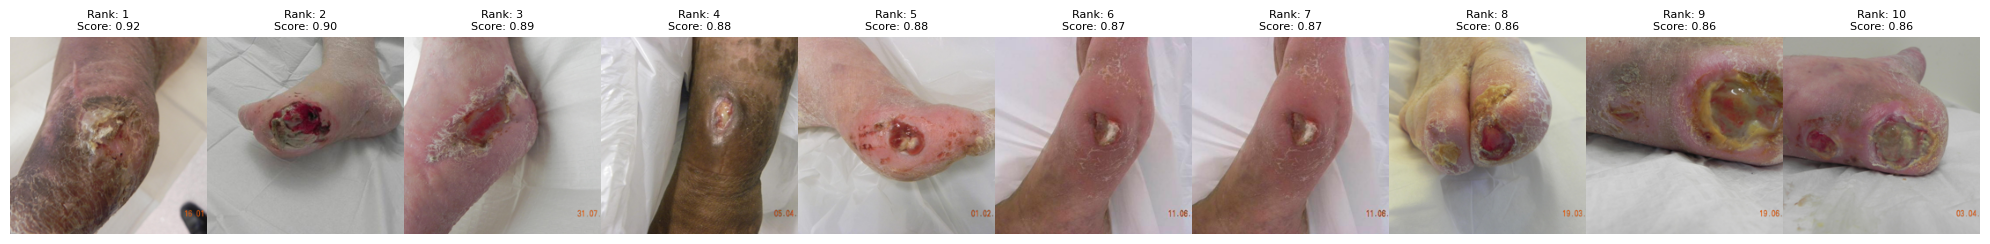

In [ ]:
example_per_concept = 10

# Create a figure
fig = plt.figure(figsize=(10 * 2, (example_per_concept // 10 + 1) * 2))

# Main GridSpec (1 row, 1 column)
main_gs = gridspec.GridSpec(1, 1, figure=fig)

# Nested GridSpec within the first subplot of main GridSpec
# Adjust rows based on examples per concept
nested_gs = gridspec.GridSpecFromSubplotSpec(
    example_per_concept // 10 + (1 if example_per_concept % 10 > 0 else 0),
    10,
    subplot_spec=main_gs[0],
    wspace=0,
    hspace=0.1,
)

# Dictionary to store axes for later use
axd = {}

for rank_num in range(example_per_concept):
    ax = plt.Subplot(fig, nested_gs[rank_num])
    fig.add_subplot(ax)

    # Generate a simple pattern for demonstration
    image = Image.open(
        image_path_list[np.argsort(concept_presence_score)[::-1][rank_num]]
    )
    # Display the image
    ax.imshow(preprocess.transforms[1](preprocess.transforms[0](image)))
    ax.axis("off")  # Remove axes for a cleaner look

    # Example key, replace with your actual key
    plot_key = rank_num
    axd[plot_key] = ax

    axd[plot_key].set_title(
        f"Rank: {rank_num + 1}\nScore: {concept_presence_score[np.argsort(concept_presence_score)[::-1][rank_num]]:.2f}",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

In [ ]:
import os
os.chdir("../")